In [1]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [6]:
def exponentialdecay_testing():
    #generation of data for testing
    x_axis = np.linspace(1, 51, 20)
    x_nice = np.linspace(x_axis[0], x_axis[-1], 100)
    
    mod, params = fitlogic.make_decayexponential_model()
    print('Parameters of the model', mod.param_names, ' with the independet variable', mod.independent_vars)

    params['amplitude'].value = -100 + abs(np.random.normal(0,200))
    params['lifetime'].value = 1 + abs(np.random.normal(0,20))
    params['offset'].value = 1 + abs(np.random.normal(0, 200))
    print('\n', 'amplitude', params['amplitude'].value, '\n', 'lifetime',
              params['lifetime'].value,'\n', 'offset', params['offset'].value)

    data_noisy = (mod.eval(x=x_axis, params=params) + 10* np.random.normal(size=x_axis.shape))
    
    result = fitlogic.make_decayexponential_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_decayexponential)
    data = data_noisy
    offset = data[-max(1,int(len(x_axis)/10)):].mean()

    #substraction of offset
    if data[0]<data[-1]:
        data_level = offset - data
    else:
        data_level = data - offset
    for i in range(0, len(x_axis)):
        if data_level[i] <= data_level.std():
            break
    print(i)
    
    try:
        data_level_log = np.log(data_level[0:i])
        linear_result = fitlogic.make_linear_fit(
            axis=x_axis[0:i],
            data=data_level_log,
            estimator=fitlogic.estimate_linear)
        plt.plot(x_axis[0:i], data_level_log, 'ob')
        plt.plot(x_axis[0:i], linear_result.best_fit,'-r')
        plt.plot(x_axis[0:i], linear_result.init_fit,'-y')
        plt.show()
    except:
        plt.plot(x_axis, np.log(data_level), 'or')
        plt.show()
        print("linear fitting poorly conditioned")
        
    plt.plot(x_axis, data_noisy, 'ob')
    plt.plot(x_nice, mod.eval(x=x_nice, params=params), '-g')
    print(result.fit_report())
    plt.plot(x_axis, result.init_fit, '-y', linewidth=2.0)
    plt.plot(x_axis, result.best_fit, '-r', linewidth=2.0)
    plt.show()


Parameters of the model ['amplitude', 'beta', 'lifetime', 'offset']  with the independet variable x

 amplitude 15.070852600544754 
 lifetime 7.899799465088136 
 offset 24.895032910706973
3
linear fitting poorly conditioned
[[Model]]
    ((Model(amplitude_function) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 55
    # data points      = 20
    # variables        = 3
    chi-square         = 2075.631
    reduced chi-square = 122.096
[[Variables]]
    beta:        1 (fixed)
    amplitude:   25.0806926 +/- 14.81741 (59.08%) (init= 36.2032)
    lifetime:    5.40812557 +/- 5.487202 (101.46%) (init= 18.42105)
    offset:      26.5365993 +/- 3.241111 (12.21%) (init= 25.37707)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, lifetime)       = -0.606 
    C(lifetime, offset)          = -0.514 



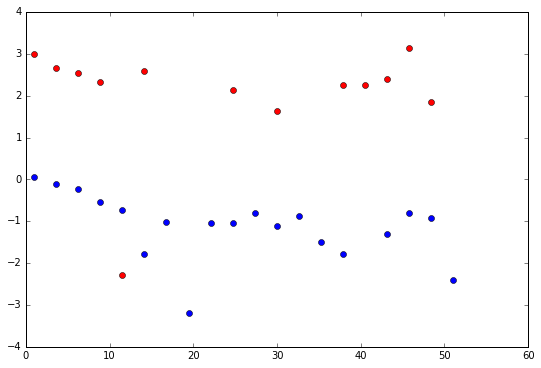

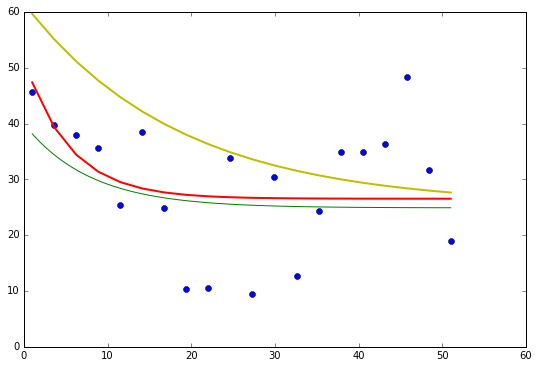

In [7]:
exponentialdecay_testing()

In [12]:
def bareexponentialdecay_testing():
    #generation of data for testing
    x_axis = np.linspace(1, 51, 20)
    x_nice = np.linspace(x_axis[0], x_axis[-1], 100)

    mod, params = fitlogic.make_bareexponentialdecay_model()
    print('Parameters of the model', mod.param_names,
          ' with the independet variable', mod.independent_vars)

    params['lifetime'].value = 1 + abs(np.random.normal(0,25))
    print('\n''lifetime', params['lifetime'].value)

    data_noisy = (mod.eval(x=x_axis, params=params) + 0.125 * np.random.normal(size=x_axis.shape))
    data = abs(data_noisy)

    nice_data = mod.eval(x=x_nice, params=params)

    for i in range(0, len(x_axis)):
        if data[i] <= data.std():
            break

    offset = data_noisy.min()

    leveled_data = data_noisy - offset

    plt.figure()
    plt.plot(x_nice, nice_data, label='ref exp. decay data no offest')
    plt.plot(x_nice, nice_data+1, label='ref exp. decay data +1 offset')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.,
               prop={'size':12}, title='ref nice data')
    plt.show()

    plt.figure()
    plt.plot(x_nice, np.log(nice_data), label='ref exp. decay data no offest, log')
    plt.plot(x_nice, np.log(nice_data+1), label='ref exp. decay data +1 offset, log')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.,
               prop={'size':12}, title='ref nice data, log')
    plt.show()


    data_log = np.log(leveled_data)

    plt.figure()
    plt.plot(x_axis, data_log, 'ob', label='logarithmic data')
    linear_result = fitlogic.make_linear_fit(
        x_axis=x_axis,
        data=data_log,
        estimator=fitlogic.estimate_linear)

    plt.plot(x_axis, linear_result.best_fit,'-r', label='best fit')
    plt.plot(x_axis, linear_result.init_fit,'-y', label='initial fit')
    plt.xlabel('Time x')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()


    result = fitlogic.make_decayexponential_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_decayexponential)
    print(result.fit_report())

    plt.figure()
    plt.plot(x_axis, data_noisy, 'ob',label='noisy data')
    plt.plot(x_nice, mod.eval(x=x_nice, params=params), '-g', label='simulated data')
    plt.plot(x_axis, result.init_fit, '-y', linewidth=1.0, label='initial values')
    plt.plot(x_axis, result.best_fit, '-r', linewidth=1.0, label='best fit')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.xlabel('Time x')
    plt.ylabel('signal')
#            plt.plot(x_axis, np.gradient(data_noisy), '-g', linewidth=2.0, )
    plt.show()

Parameters of the model ['beta', 'lifetime']  with the independet variable x

lifetime 26.937591660828453
[[Model]]
    ((Model(amplitude_function) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 20
    # variables        = 3
    chi-square         = 0.333
    reduced chi-square = 0.020
[[Variables]]
    beta:        1 (fixed)
    amplitude:   1.64356259 +/- 0.771432 (46.94%) (init= 1.09293)
    lifetime:    51.6290705 +/- 41.88436 (81.13%) (init= 34.21053)
    offset:     -0.63378230 +/- 0.834286 (131.64%) (init=-0.01581119)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, offset)         = -0.995 
    C(lifetime, offset)          = -0.991 
    C(amplitude, lifetime)       =  0.975 



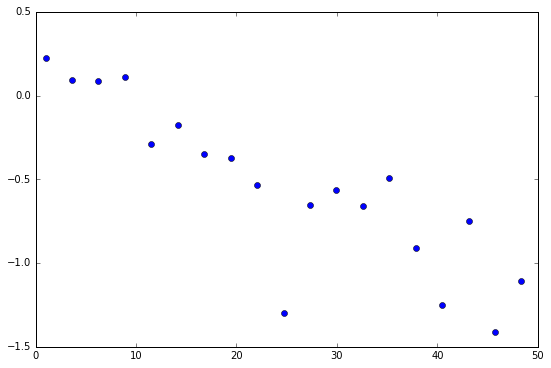

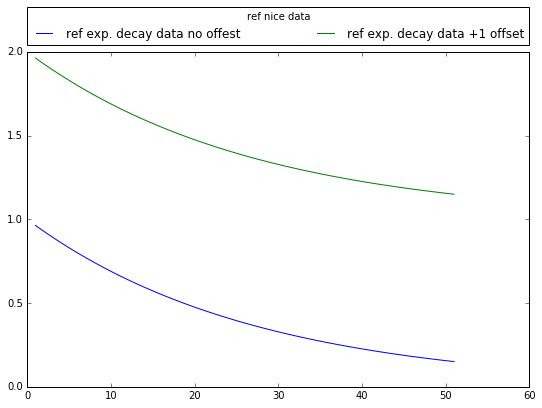

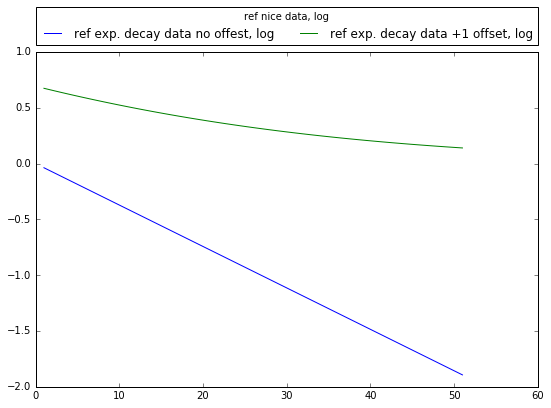

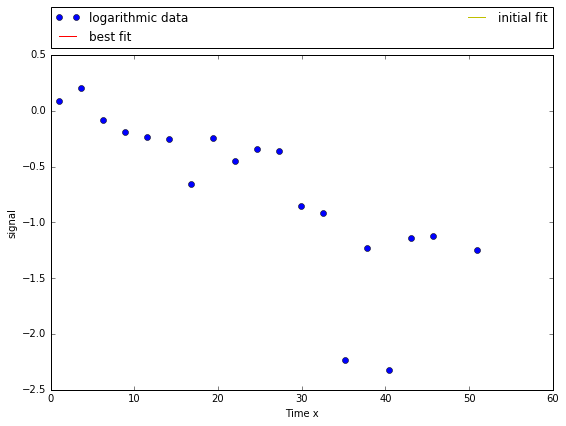

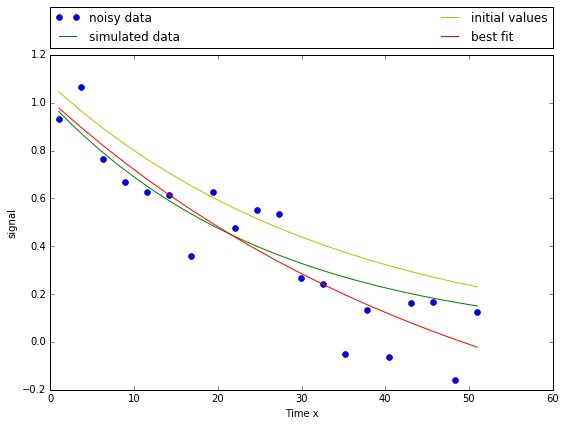

In [13]:
bareexponentialdecay_testing()